<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/03%20-%20Advanced%20experiments%20design/01_proxy_metrics.ipynbipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

### Загрузим данные

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/aleks-haksly/Study/main/Data/proxy_metrics_homework_3.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              1193 non-null   int64  
 1   views                1193 non-null   int64  
 2   contacts             1193 non-null   int64  
 3   last_7_views         1193 non-null   int64  
 4   last_3_views         1193 non-null   int64  
 5   last_7_contacts      1193 non-null   int64  
 6   last_3_contacts      1193 non-null   int64  
 7   live_days            1193 non-null   int64  
 8   messages_events      1193 non-null   int64  
 9   max_views_delta      1193 non-null   int64  
 10  add_to_favor_events  1193 non-null   float64
 11  is_bought            1193 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 112.0 KB


### Задание 1. EDA (1/6) ###
Найдите среднюю конверсию в покупку авто для пользователей.

In [ ]:
data.is_bought.mean()

0.3403185247275775

### Задание 1. EDA (2/6) ###
Какое среднее количество контактов за весь период у тех, кто не купил авто в итоге?

In [ ]:
round(data.query("is_bought == 0")['contacts'].mean(), 2)

12.98

### Задание 1. EDA (3/6) ###
Посчитайте, во сколько раз среднее количество добавлений в избранное (add_to_favor_events) отличается для каждой из двух когорт (тех, кто купил авто и тех, кто не купил авто).

In [ ]:
round(data.query("is_bought == 1")['add_to_favor_events'].mean() / data.query("is_bought == 0")['add_to_favor_events'].mean(), 2)

2.03

### Задание 1. EDA (4/6) ###
Найдите долю пользователей, кто не совершил ни одного контакта для каждой из двух когорт (тех, кто купил авто и тех, кто не купил авто).

В ответе укажите долю среди тех, кто купил авто.

In [ ]:
round(data.query("is_bought == 1 and contacts == 0")['contacts'].count() / data.query("is_bought == 1")['contacts'].count(), 2)

0.04

### Задание 1. EDA (5/6) ###
Найдите средний LT (lifetime — длительность от первого дня до ухода в отток) для двух когорт. Как вы думаете, с чем может быть связано различие в длительности?

В ответе укажите LT пользователей, которые купили авто.

In [ ]:
data.groupby('is_bought').live_days.mean().apply(lambda x: round(x, 2))

is_bought
0    12.72
1    10.22
Name: live_days, dtype: float64

### Задание 1. EDA (6/6) ###
Найдите отношение между просмотрами и контактами для двух когорт. Как вы думаете, почему есть такие различия в этом параметре?
В ответе укажите отношение контактов к просмотрам в когорте купивших авто.

In [ ]:
data1 = data.query("views > 0")[:]
data1['contr'] = np.vectorize(lambda x, y: x/y)(data1['contacts'], data1['views'])
data1.groupby('is_bought').contr.mean().apply(lambda x: round(x, 2))

is_bought
0    0.02
1    0.03
Name: contr, dtype: float64

### Задание 2. Поиск корреляции (1/2) ###
Пройдитесь по всем метрикам из исходных данных и найдите TOP-3 метрики, которые дают наилучшую корреляцию с фактом покупки авто.

#### Метод 1 с использованием логичтической регресии ####

In [ ]:
# Отделим в датасете целевую переменную is_bought от признаков
X = data.drop('is_bought', axis = 1)
Y = data['is_bought']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV , LogisticRegression

In [ ]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
log_model = LogisticRegression()
log_model.fit(scaled_X, Y)

LogisticRegression()

In [ ]:
rating = dict()
for i, cname in enumerate(X.columns):
    rating[cname] =  log_model.coef_[0][i]

In [ ]:
rating

{'user_id': 0.08041048001364157,
 'views': 0.2515393440607556,
 'contacts': 0.38585834687541626,
 'last_7_views': -0.6746569369941261,
 'last_3_views': 0.7262469745959785,
 'last_7_contacts': 0.16386059741680964,
 'last_3_contacts': 0.6581500497735422,
 'live_days': -0.2378841786877579,
 'messages_events': -0.45338995531236104,
 'max_views_delta': 0.18062628265753028,
 'add_to_favor_events': 0.13839518401400866}

In [ ]:
sorted(rating, key = lambda x: abs(rating.get(x)), reverse = True)[:3]

['last_3_views', 'last_7_views', 'last_3_contacts']

<Axes: >

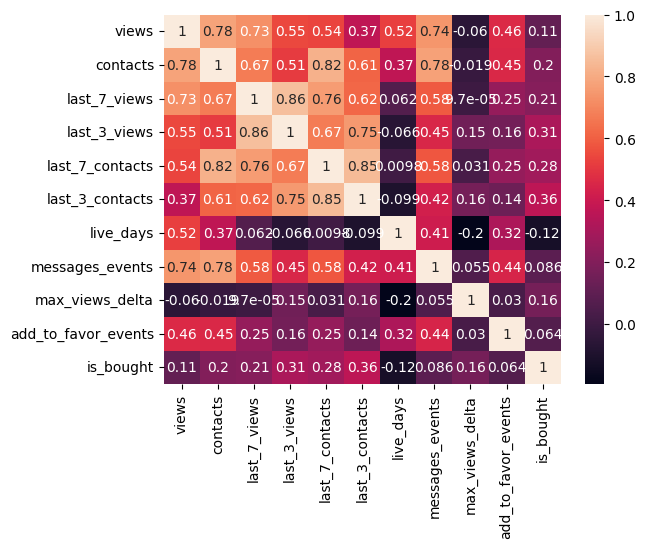

In [ ]:
sns.heatmap(data.drop("user_id", axis=1).corr(), annot = True)

In [ ]:
pd.DataFrame(data.drop("user_id", axis=1).
             corr()['is_bought'].sort_values(ascending = False).
             reset_index().
             rename(columns = {'index':'feature', 'is_bought': 'corr'})).iloc[1:]

,feature,corr
1,last_3_contacts,0.363262
2,last_3_views,0.311280
3,last_7_contacts,0.284834
4,last_7_views,0.208163
5,contacts,0.198719
6,max_views_delta,0.160610
7,views,0.109637
8,messages_events,0.086318
9,add_to_favor_events,0.063673
10,live_days,-0.124886


### Задание 3. Новые метрики (1/5) ###
Исходя из найденных корреляций, попробуйте предложить новые метрики, которые дадут бОльшую корреляцию. И посчитать, какое новое значение корреляции удалось достичь.
Попробуем логарифмирование основных метрик. Не забываем добавлять единицу, чтобы избавиться от нулей в данных.
Рассчитайте коэффициент point biserial correlation для логарифма метрики (last_3_contacts + 1).

In [ ]:
data['log_last_3_contacts'] = np.log(data['last_3_contacts'] + 1)
find_cat_quant_correlation(quant_value = data['log_last_3_contacts'], binary_mask=data['is_bought']==1, plot = False, print_inference = False)

{'point biserial R': 0.4189125444689098,
 'kruskal_pval': 2.2215577772866467e-45,
 'ttest_pval': 6.846453497217277e-52}

### Задание 3. Новые метрики (2/5) ###
Рассчитайте коэффициент point biserial correlation для логарифма метрики (last_3_views + 1).
Введите ответ в поле ниже с точностью до двух знаков после запятой. Используйте точку в качестве разделителя целой и дробной части.

In [ ]:
data['log_last_3_views'] = np.log(data['last_3_views'] + 1)
find_cat_quant_correlation(quant_value = data['log_last_3_views'], binary_mask=data['is_bought']==1, plot = False, print_inference = False)

{'point biserial R': 0.35176836778116505,
 'kruskal_pval': 1.7667452180529188e-35,
 'ttest_pval': 4.4951974177508544e-36}

### Задание 3. Новые метрики (3/5) ###
Рассчитайте коэффициент point biserial correlation для логарифма метрики (add_to_favor_events + 1).

In [ ]:
data['log_add_to_favor_events'] = np.log(data['add_to_favor_events'] + 1)
find_cat_quant_correlation(quant_value = data['log_add_to_favor_events'], binary_mask=data['is_bought']==1, plot = False, print_inference = False)

{'point biserial R': 0.16717393485118104,
 'kruskal_pval': 3.566563459009145e-18,
 'ttest_pval': 6.283513666365396e-09}

### Задание 3. Новые метрики (4/5) ###
Попробуем найти соотношение основных метрик.
Рассчитайте коэффициент point biserial correlation для метрики (last_3_contacts / (last_3_views +1)).

In [ ]:
data["last_3_contacts_per_views"] = data['last_3_contacts'] / (data['last_3_views'] + 1)
find_cat_quant_correlation(quant_value = data["last_3_contacts_per_views"], binary_mask=data['is_bought']==1, plot = False, print_inference = False)

{'point biserial R': 0.11477565368175353,
 'kruskal_pval': 3.654464866764808e-18,
 'ttest_pval': 7.087975671932094e-05}

### Задание 4. Порог для прокси-метрики (1/2) ###
Найдите порог для прокси-метрики last_3_contacts.

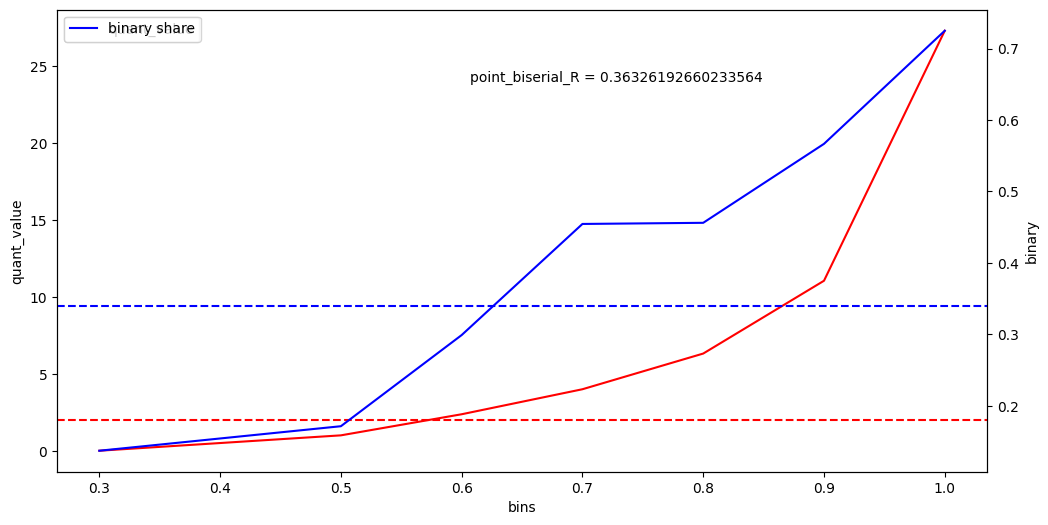

In [ ]:
proxy_metrics_bins_analizer(quant_value = data['last_3_contacts'], binary_mask=data['is_bought']==1, step=0.1)

Maximum Cramer V = 0.3672697346990414
Maximum Cramer V quant value =  3


{'max_cramer_v': 0.3672697346990414, 'max_corr_quant_value': 3}

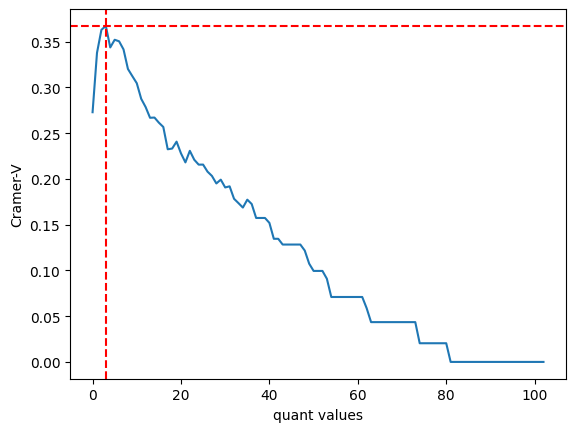

In [ ]:
max_cramerv_corr_finder(quant_value = data['last_3_contacts'], binary_mask=data['is_bought']==1, step=1)

### Задание 4. Порог для прокси-метрики (2/2) ###
Найдите порог для прокси-метрики last_3_views.

In [ ]:
max_cramerv_corr_finder(data['last_3_views'], data['is_bought']==1, plot = False, print_inference = False, step = 1)

{'max_cramer_v': 0.3486475362928702, 'max_corr_quant_value': 151}

### Задание 5. Мощность (1/3) ###
Предположим, что мы выбрали как прокси-метрику набор контактов за последние три дня. Порог мы нашли. Теперь нужно рассчитать, сможем ли мы использовать это на практике.
Рассчитайте мощность z-теста для исходной целевой метрики (доля тех, кто купил) и прокси-метрики (тех, у кого было больше 3 контактов за три дня).
Для оценки мощности используйте следующие вводные:
проводим анализ на тех данных, которые есть в файле через проведение синтетических тестов
количество симуляций 10000
размер добавляемого эффекта +10% к конверсии в тестовой группе для обоих типов теста (для основной метрики и для прокси-метрики) <br>
**Найдите мощность А/Б-теста по целевой метрике.**

In [ ]:
#AB test simulation

ab_binary_ztest_pvalue_list = []
ab_quant_ztest_pvalue_list = []
quant_target_level = 3
abs_effect = 0.1
n_sim = 10000

for i in range(n_sim):
    sample_mask = ss.bernoulli.rvs(0.5, size=len(data)) == 1

    binary_mask_group_a = (data['is_bought']==1)[sample_mask]
    binary_mask_group_b = (data['is_bought']==1)[~sample_mask]
    quant_value_group_a = (data['last_3_contacts'])[sample_mask]
    quant_value_group_b = (data['last_3_contacts'])[~sample_mask]

    binary_nobs_group_a = len(binary_mask_group_a)
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)

    binary_counts_group_a = binary_mask_group_a.sum()
    binary_counts_group_b = round(binary_mask_group_b.sum()*(1+abs_effect)) #add effect
    quant_counts_group_a = (quant_value_group_a >= quant_target_level).sum()
    quant_counts_group_b = round((quant_value_group_b >= quant_target_level).sum()*(1+abs_effect)) #add effect

    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

    ab_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    ab_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

binary_power_ci = proportion_confint((np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_power_ci = proportion_confint((np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)

print('Effect =', abs_effect)
print('Sample size A group =', binary_nobs_group_a)
print('Sample size B group =', binary_nobs_group_b)

print('Target conversion A group = ', binary_counts_group_a / binary_nobs_group_a)
print('Target conversion B group = ', binary_counts_group_b / binary_nobs_group_b)
print('Proxy conversion A group = ', quant_counts_group_a / quant_nobs_group_a)
print('Proxy conversion B group = ', quant_counts_group_b / quant_nobs_group_b)



print('Мощность АБ-теста по целевой метрике', (np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum() / n_sim)
print('99%-процентный доверительный интервал для мощности (доля продавших)', binary_power_ci)


print('Мощность АБ-теста по прокси метрике', (np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum() / n_sim)

Effect = 0.1
Sample size A group = 601
Sample size B group = 592
Target conversion A group =  0.30782029950083195
Target conversion B group =  0.41047297297297297
Proxy conversion A group =  0.4858569051580699
Proxy conversion B group =  0.5253378378378378
Мощность АБ-теста по целевой метрике 0.2407
99%-процентный доверительный интервал для мощности (доля продавших) (0.2296881110099597, 0.25171188899004027)
Мощность АБ-теста по прокси метрике 0.3849


In [ ]:
binary_power_ci

(0.23195239453702995, 0.25404760546297)

In [ ]:
data.head(10)

,user_id,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,messages_events,max_views_delta,add_to_favor_events,is_bought
0,151042503,84,2,84,39,2,2,8,0,6,0.0,0
1,151212422,95,0,95,36,0,0,8,0,7,0.0,0
2,151206815,118,3,118,40,3,2,8,0,2,0.0,0
3,151284254,11,0,11,2,0,0,7,0,8,0.0,0
4,151088604,48,2,48,8,2,0,8,0,1,0.0,0
5,150999609,82,0,82,8,0,0,8,0,3,0.0,0
6,151004829,358,8,358,139,8,3,8,0,8,0.0,0
7,151080266,62,0,62,17,0,0,8,0,3,0.0,0
8,151075531,61,3,61,19,3,0,8,0,1,0.0,0
9,151276320,148,1,148,25,1,0,8,0,4,0.0,0


### Вспомним алгоритм работы с прокси-метриками и напишем функцию для проверки корреляции

Полезные ссылки по расчету корреляций между категориальными и количественными переменными:

- https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365
- https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient
- https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781118445112.stat06227
- https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

Алгоритм работы с прокси метриками:
- найти хороших кандидатов на прокси метрики
- провести корреляционный анализ
- доработать первичный список
- проверить мощность и уровень значимости теста
- проверить на реальном АБ-тесте позволяет ли прокси-метрика детектить изменение целевой метрики. Анализ чувствительности прокси-метрики

In [ ]:
# напишем функцию, которая проверяет наличие корреляции
# между категориальной и количественной переменной

def find_cat_quant_correlation(quant_value, binary_mask, plot = True, print_inference = True, colnames = True):
    '''
    quant_value - количественная переменная,  для которой считаем корреляцию
    binary_mask - бинарная переменная (True, False), для которой считаем корреляцию
    plot - надо ли отрисовывать график
    print_inference - надо ли принтовать выводы и основные метркии
    '''

    # разбиваем количественную метрику на группы по тому, была ли целевая конверсия или нет
    group_1 = quant_value[binary_mask] # binary = 1
    group_2 = quant_value[~binary_mask] # binary = 0

    # считаем pointbiserial корреляцию, тест Краскелла-Уолесса и обычный Т-тест
    pointbiserialr = ss.pointbiserialr(quant_value, binary_mask)[0]
    kruskal_pval = ss.kruskal(group_1, group_2)[1]
    ttest_pval = ss.ttest_ind(group_1, group_2)[1]

    # принтуем выводы
    if print_inference:
        print('Mean quant value for group (binary=1) =', group_1.mean())
        print('Mean quant value for group (binary=0) =', group_2.mean())

        print('Median quant value for group (binary=1) =', group_1.median())
        print('Median quant value for group (binary=0) =', group_2.median())

        print('Kruskal-Wallis H Test p-value =', kruskal_pval)
        print('T-test p-value =', ttest_pval)
        print('point biserial correlation =', pointbiserialr)

    # рисуем график распределения для двух групп, чтобы проиллюстрировать различия в группах
    if plot:
        plt.figure(figsize=(16,6))
        sns.kdeplot(group_1, color = 'red', label = 'Binary = True')
        sns.kdeplot(group_2, color = 'blue', label = 'Binary = False')
        plt.axvline(x = group_1.mean(), linestyle = '--', color = 'red')
        plt.axvline(x = group_2.mean(), linestyle = '--', color = 'blue')
        plt.legend()

    if colnames:
        return({'point biserial R':pointbiserialr,
                'kruskal_pval':kruskal_pval,
                'ttest_pval':ttest_pval})
    return [pointbiserialr,
            kruskal_pval,
            ttest_pval]

In [ ]:
correlation_rating = dict()
for _ in X.columns:
    correlation_rating[_] = (find_cat_quant_correlation(quant_value = data[_], \
                                                        binary_mask=data['is_bought']==1,\
                                                        plot = False, \
                                                        print_inference = False, \
                                                        colnames=False))

In [ ]:
pd.DataFrame(correlation_rating, index=['pointbiserialr', 'kruskal_pval', 'ttest_pval']).T.sort_values('pointbiserialr', ascending = False)

,pointbiserialr,kruskal_pval,ttest_pval
last_3_contacts,0.363262,2.221558e-45,1.592043e-38
last_3_views,0.311280,1.766745e-35,3.231466e-28
last_7_contacts,0.284834,2.187389e-29,1.054346e-23
last_7_views,0.208163,8.991524e-13,3.811776e-13
contacts,0.198719,5.543070e-19,4.338095e-12
max_views_delta,0.160610,9.310520e-01,2.434716e-08
views,0.109637,5.306506e-05,1.480471e-04
messages_events,0.086318,1.466459e-06,2.846538e-03
add_to_favor_events,0.063673,3.566563e-18,2.786382e-02
user_id,0.063328,1.913844e-11,2.872480e-02


{'point biserial R': 0.19871891825759605,
 'kruskal_pval': 5.543069998568082e-19,
 'ttest_pval': 4.33809546483678e-12}

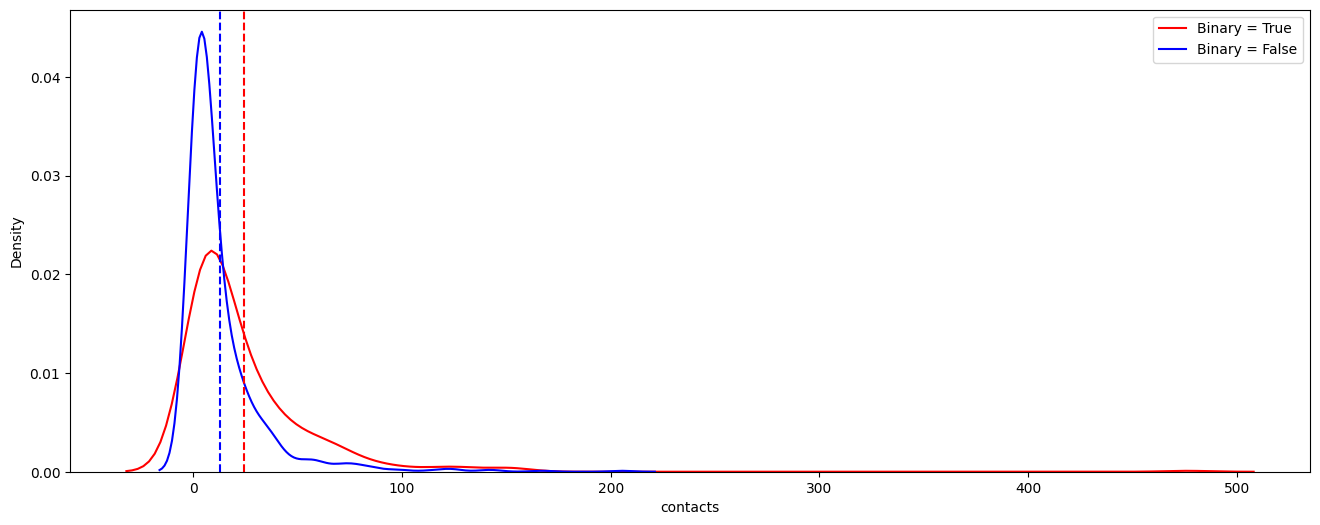

In [ ]:
find_cat_quant_correlation(quant_value = data['contacts'], binary_mask=data['is_bought']==1, plot = True, print_inference = False)

### Ищем пороги для прокси-метрики

In [ ]:
# напишем функцию для визуализации и поиска оптимальных порогов для создания прокси-метрики

def proxy_metrics_bins_analizer(quant_value, binary_mask, step):

    #разбиваем исходную количественную величину на квантили с нужным шагом
    deciles_bins = np.quantile(quant_value, np.arange(0, 1, step))
    #разбиваем ряд на бины
    inds = np.digitize(quant_value, deciles_bins, right = False)
    # агрегируем
    df = pd.DataFrame({'quant_value':quant_value,
                  'binary': binary_mask,
                  'bins': inds})
    inference = df.groupby('bins').mean()

    #считаем point biserial корреляцию
    point_biserial_R = find_cat_quant_correlation(quant_value = quant_value, binary_mask=binary_mask, plot = False, print_inference = False)['point biserial R']

    # рисуем график
    plt.figure(figsize=(12,6))
    sns.lineplot(y = inference['quant_value'], x = inference.index*step, color = 'red', label = 'quant_value')
    plt.axhline(y = quant_value.median(), linestyle = '--', color = 'red')
    plt.text(x = inds.mean()*step, y = np.quantile(quant_value, 0.95), s ='point_biserial_R = {}'.format(point_biserial_R), )
    ax2 = plt.twinx()
    sns.lineplot(y = inference['binary'], x = inference.index*step, color = 'blue', ax=ax2, label = 'binary share')
    plt.axhline(y = binary_mask.mean(), linestyle = '--', color = 'blue')
    plt.legend()

### Рассмотрим метрику Просмотры

Посмотрим, есть ли различия в распределении просмотров в зависимости от того, продали ли авто или нет

Mean quant value for group (binary=1) = 1021.3300492610838
Mean quant value for group (binary=0) = 730.4294790343075
Median quant value for group (binary=1) = 503.0
Median quant value for group (binary=0) = 368.0
Kruskal-Wallis H Test p-value = 5.3065061016086465e-05
T-test p-value = 0.0001480470649402244
point biserial correlation = 0.10963715907458788


{'point biserial R': 0.10963715907458788,
 'kruskal_pval': 5.3065061016086465e-05,
 'ttest_pval': 0.0001480470649402244}

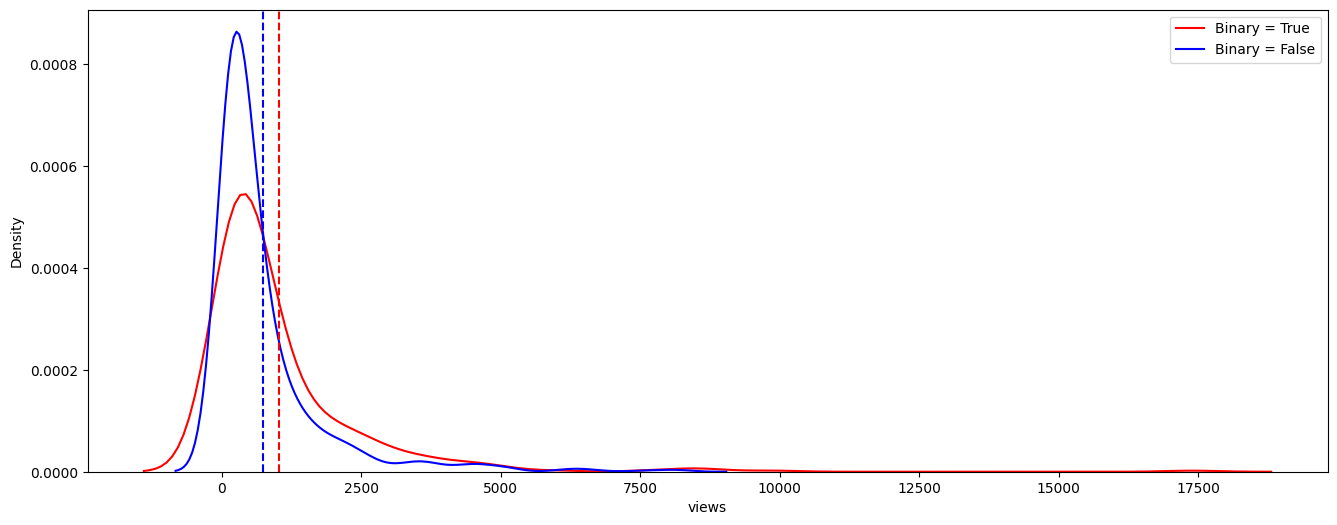

In [ ]:
find_cat_quant_correlation(quant_value = data['views'], binary_mask=data['is_bought']==1, plot = True, print_inference = True)

Видим, что распределения и средние явно различаются (стат критерии показывают различия в средних), но корреляция недостаточно высокая.

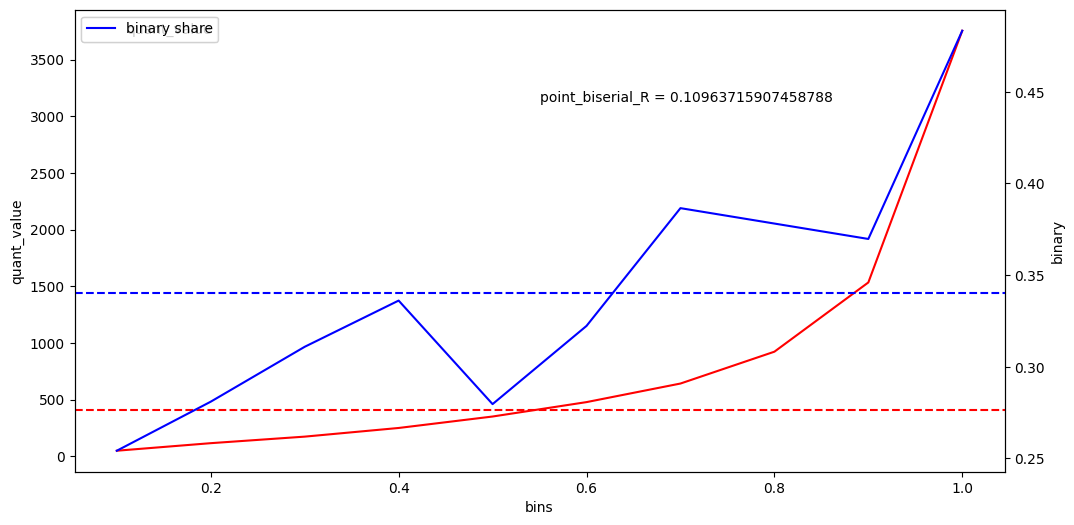

In [ ]:
proxy_metrics_bins_analizer(quant_value = data['views'], binary_mask=data['is_bought']==1, step = 0.1)

Есть скачок конверсии после 0,6 квантиля.

В целом видно, что просмотры отлавливают влияние на рост вероятности продать авто. Но видно, что есть много других факторов, размывающих влияние. Попробуем поискать еще хорошие варианты метрик

### Рассмотрим метрику суммарные контакты

Mean quant value for group (binary=1) = 24.32512315270936
Mean quant value for group (binary=0) = 12.978398983481576
Median quant value for group (binary=1) = 12.0
Median quant value for group (binary=0) = 6.0
Kruskal-Wallis H Test p-value = 5.543069998568082e-19
T-test p-value = 4.33809546483678e-12
point biserial correlation = 0.19871891825759605


{'point biserial R': 0.19871891825759605,
 'kruskal_pval': 5.543069998568082e-19,
 'ttest_pval': 4.33809546483678e-12}

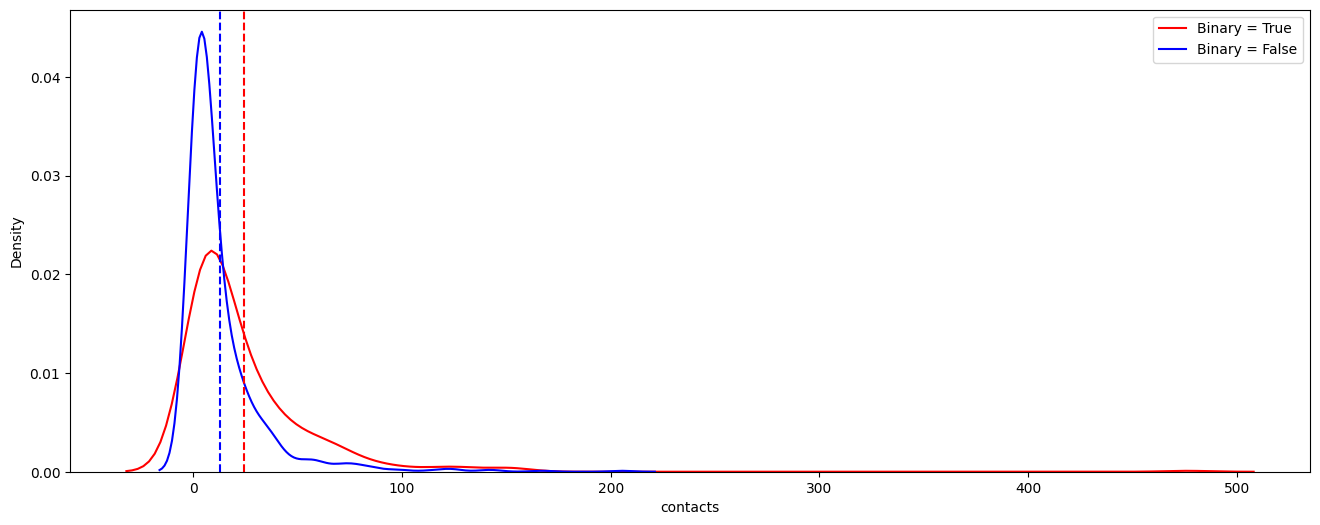

In [ ]:
find_cat_quant_correlation(quant_value = data['contacts'], binary_mask=data['is_bought']==1, plot = True, print_inference = True)

Мера различий между группами (p-value в критериях) выглядит более значимой. Так же, как и уровень корреляции. Значит, мы двигаемся в правильном направлении.

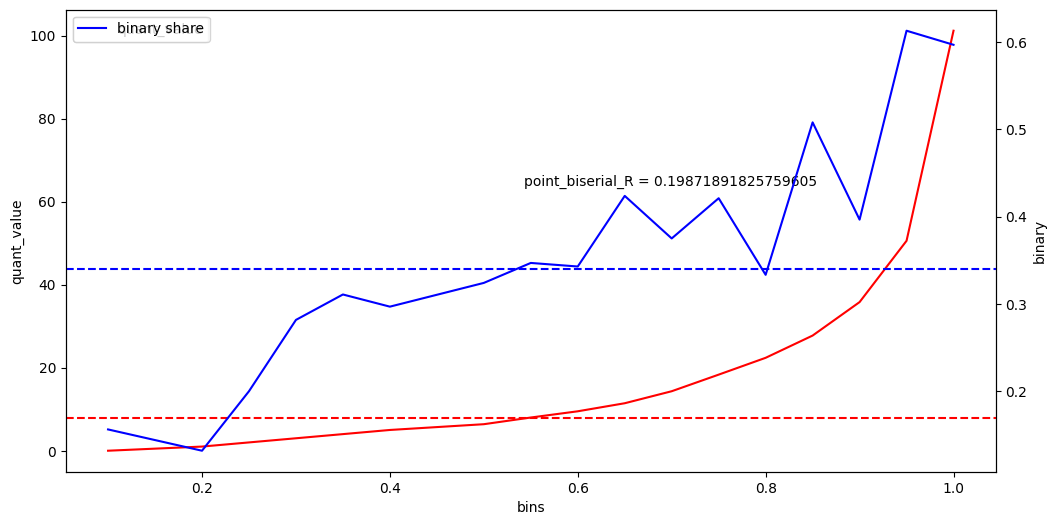

In [ ]:
proxy_metrics_bins_analizer(quant_value = data['contacts'], binary_mask=data['is_bought']==1, step = 0.05)

Видно, что между контактами и долей проданных автомобилей есть корреляция

### Преобразуем немного метрику контактов

Mean quant value for group (binary=1) = 2.621626730765931
Mean quant value for group (binary=0) = 1.9647865738535728
Median quant value for group (binary=1) = 2.5649493574615367
Median quant value for group (binary=0) = 1.9459101490553132
Kruskal-Wallis H Test p-value = 5.543069998568082e-19
T-test p-value = 6.240407228686518e-20
point biserial correlation = 0.2603217975063433


{'point biserial R': 0.2603217975063433,
 'kruskal_pval': 5.543069998568082e-19,
 'ttest_pval': 6.240407228686518e-20}

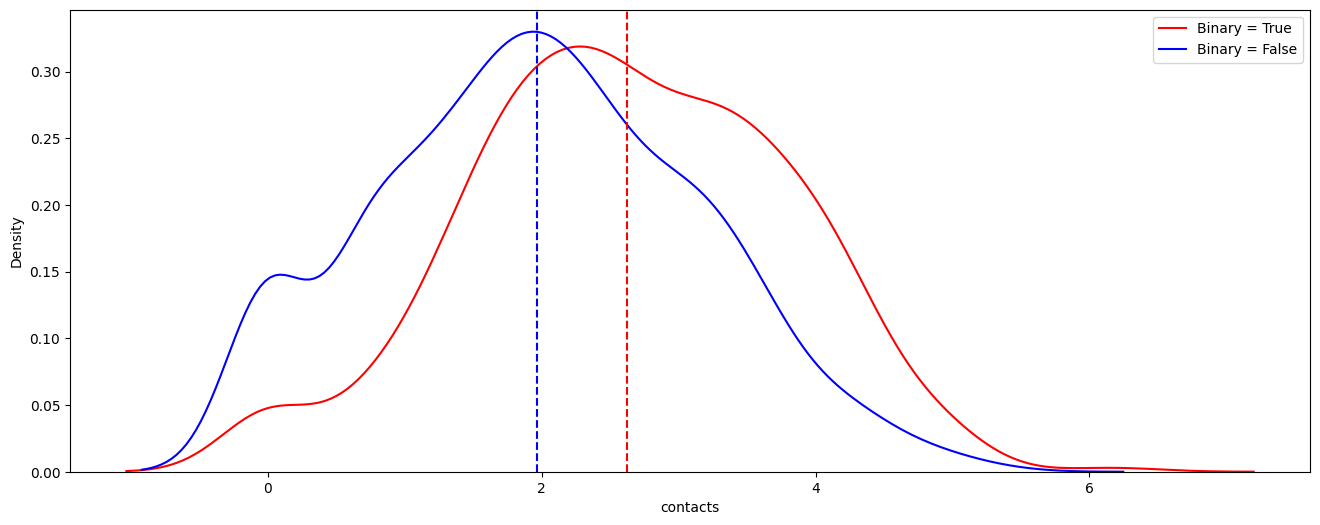

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['contacts']+1), binary_mask=data['is_bought']==1, plot = True, print_inference = True)

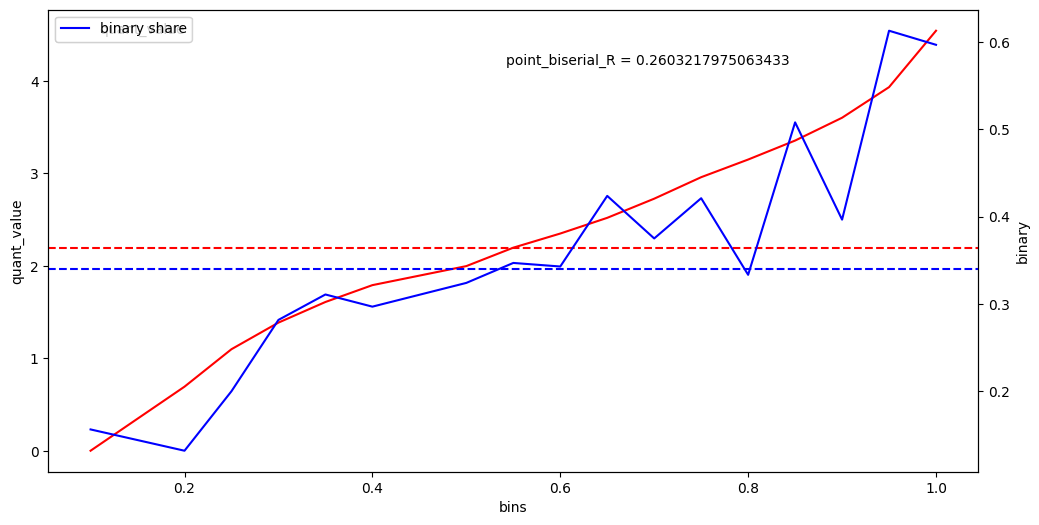

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['contacts']+1), binary_mask=data['is_bought']==1, step = 0.05)

После преобразования метрики контактов корреляция стала видна еще сильнее. То, что логарифм работает на корреляцию лучше, говорит о том, что вероятность сконтактировать прирастает нелинейно от количества контактов.

### Рассмотрим метрику live days

Кажется, что количество проведенных в листинге дней также должно повышать вероятность продажи. Давайте рассмотрим, как эта метрика влияет на вероятность продажи.

Mean quant value for group (binary=1) = 10.219211822660098
Mean quant value for group (binary=0) = 12.72299872935197
Median quant value for group (binary=1) = 8.0
Median quant value for group (binary=0) = 8.0
Kruskal-Wallis H Test p-value = 4.349845742932125e-14
T-test p-value = 1.5187583714796581e-05
point biserial correlation = -0.12488555151409071


{'point biserial R': -0.12488555151409071,
 'kruskal_pval': 4.349845742932125e-14,
 'ttest_pval': 1.5187583714796581e-05}

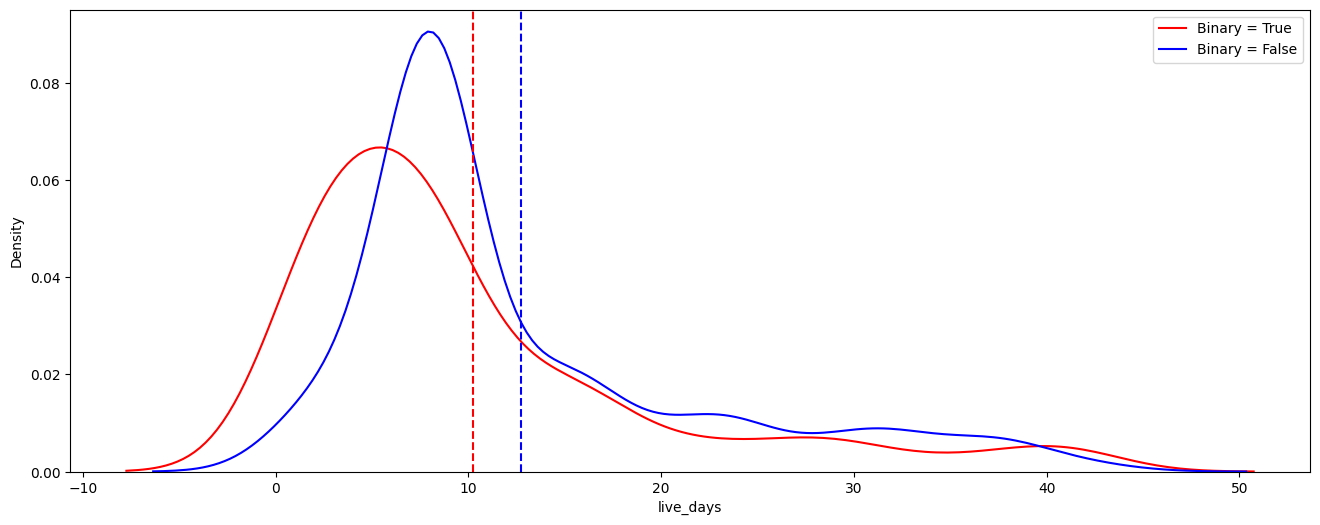

In [ ]:
find_cat_quant_correlation(quant_value = (data['live_days']), binary_mask=data['is_bought']==1, plot = True, print_inference = True)

Видно, что длительность пребывания в live влияет на вероятность продать автомобиль. При этом вероятность падает с ростом длительности присутствия в live. Также кажется, что влияние длительности нелинейное, поэтому попробуем преобразовать метрику.

Mean quant value for group (binary=1) = 1.9116519471903581
Mean quant value for group (binary=0) = 2.3028244699408007
Median quant value for group (binary=1) = 2.0794415416798357
Median quant value for group (binary=0) = 2.0794415416798357
Kruskal-Wallis H Test p-value = 4.349845742932125e-14
T-test p-value = 3.086085284709426e-15
point biserial correlation = -0.22564124391151355


{'point biserial R': -0.22564124391151355,
 'kruskal_pval': 4.349845742932125e-14,
 'ttest_pval': 3.086085284709426e-15}

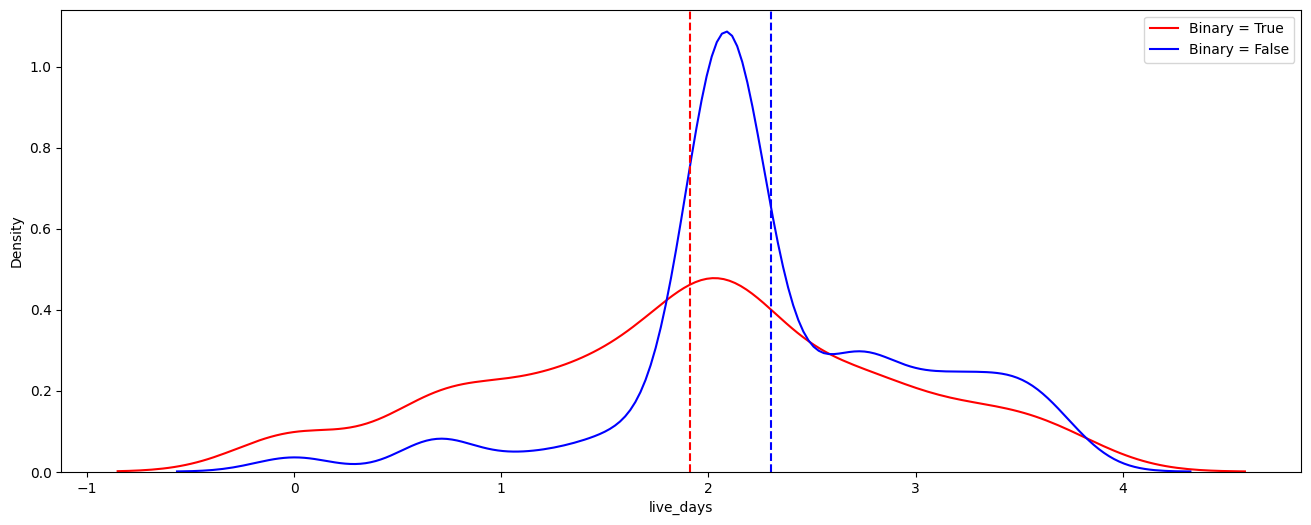

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['live_days']), binary_mask=data['is_bought']==1, plot = True, print_inference = True)

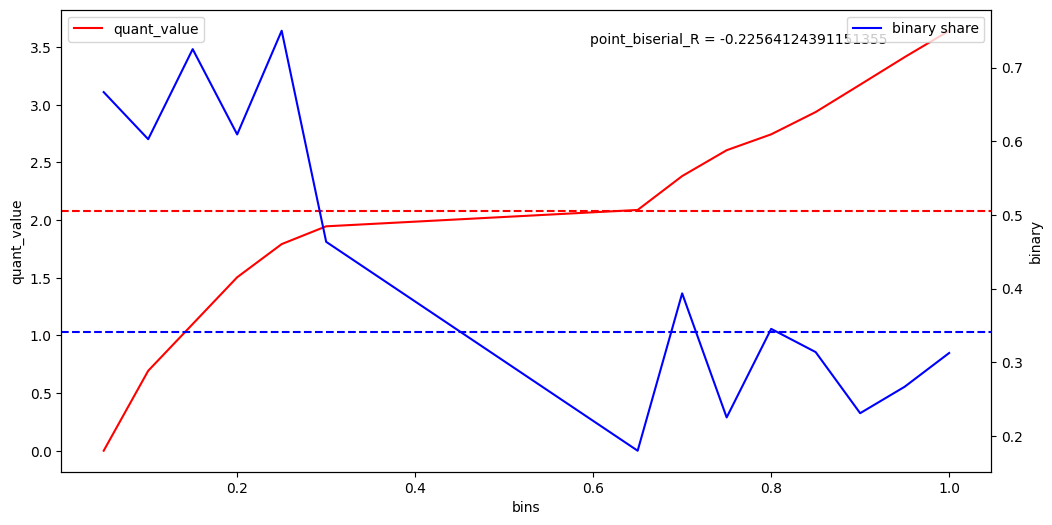

In [ ]:
proxy_metrics_bins_analizer( np.log(data['live_days']), binary_mask=data['is_bought']==1, step = 0.05)

Видим, что метрика длительности пребывания в тесте важная для определения вероятности совершения продажи. Но сама по себе все еще несет не достаточно сильную корреляцию.

### Рассмотрим соотношение контактов к просмотрам

Кажется, что хорошим кандидатом на прокси-метрику, предсказывающим вероятность совершения контактов может быть соотношение контактов к просмотрам у объявления. "Хорошее" объявление должно набирать большее кол-во контактов на объем просмотров. Проверим это предположение.

Mean quant value for group (binary=1) = 0.033949018945266404
Mean quant value for group (binary=0) = 0.022613636963451107
Median quant value for group (binary=1) = 0.025458075262762763
Median quant value for group (binary=0) = 0.015220700152207
Kruskal-Wallis H Test p-value = 8.567613106788912e-17
T-test p-value = 5.546395115966197e-10
point biserial correlation = 0.17832984360077844


{'point biserial R': 0.17832984360077844,
 'kruskal_pval': 8.567613106788912e-17,
 'ttest_pval': 5.546395115966197e-10}

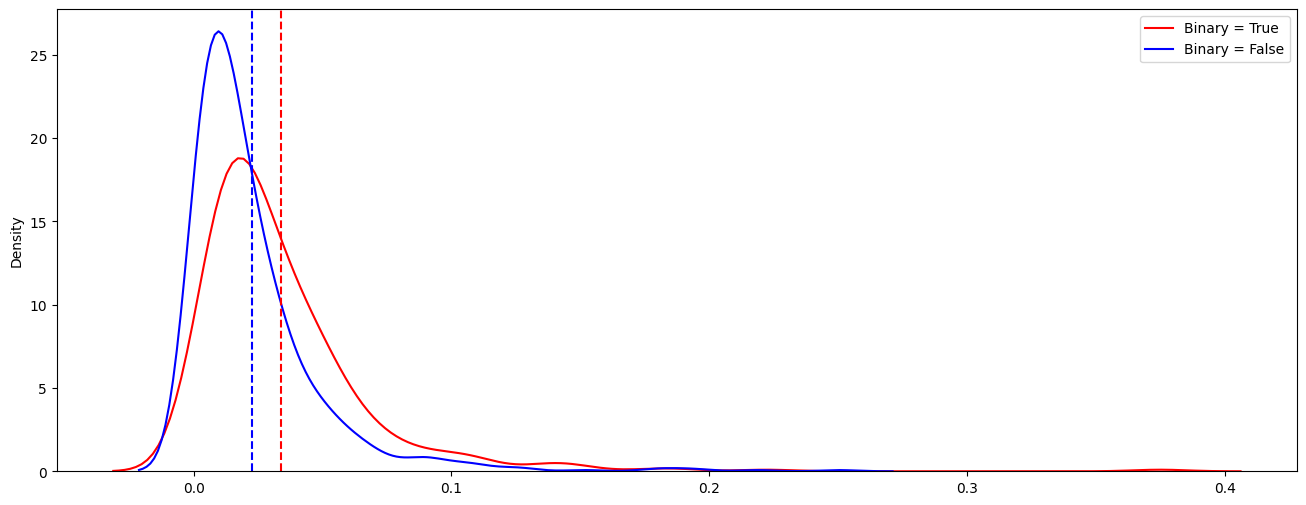

In [ ]:
find_cat_quant_correlation(quant_value = data['contacts'] / (data['views']+1), binary_mask=data['is_bought']==1, plot = True, print_inference = True)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


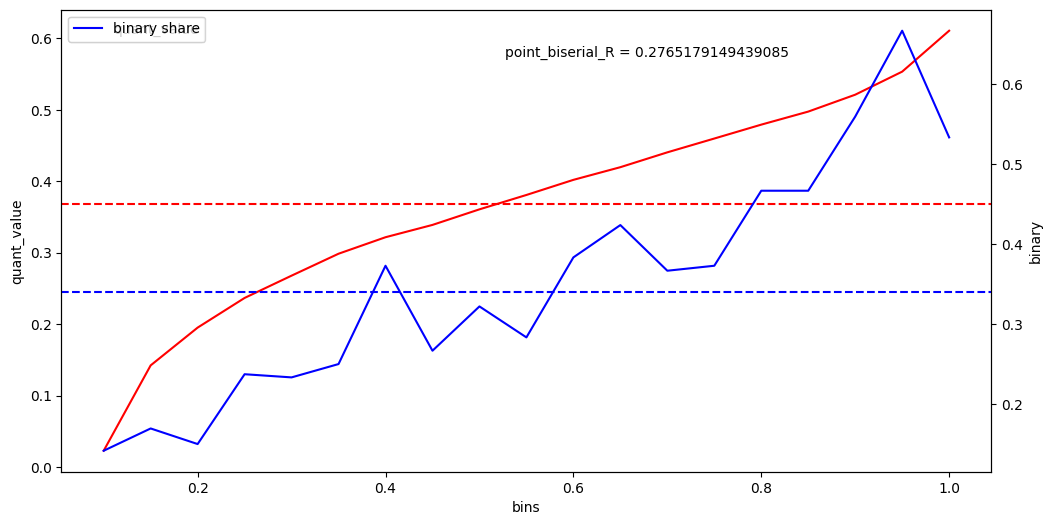

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['contacts']+1) / np.log(data['views']), binary_mask=data['is_bought']==1, step = 0.05)

### Рассмотрим скорость набора контактов (в зависимости от кол-ва дней в live)

Кажется, что чем быстрее объявление набирает контакты, тем вероятнее произойдет продажа. Проверим это предположение.

Mean quant value for group (binary=1) = 2.782297060118942
Mean quant value for group (binary=0) = 1.109947479554732
Median quant value for group (binary=1) = 1.6666666666666667
Median quant value for group (binary=0) = 0.64
Kruskal-Wallis H Test p-value = 1.3008928681069028e-43
T-test p-value = 1.5617939295591454e-35
point biserial correlation = 0.3491665606196702


{'point biserial R': 0.3491665606196702,
 'kruskal_pval': 1.3008928681069028e-43,
 'ttest_pval': 1.5617939295591454e-35}

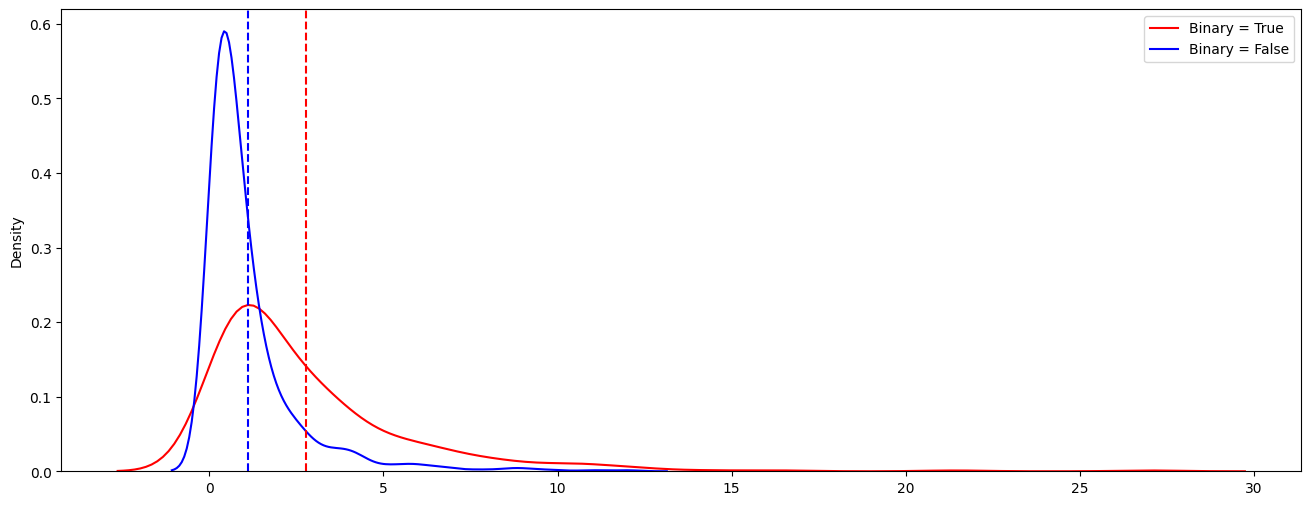

In [ ]:
find_cat_quant_correlation(quant_value = (data['contacts']+1) / (data['live_days']+1), binary_mask=data['is_bought']==1, plot = True, print_inference = True)

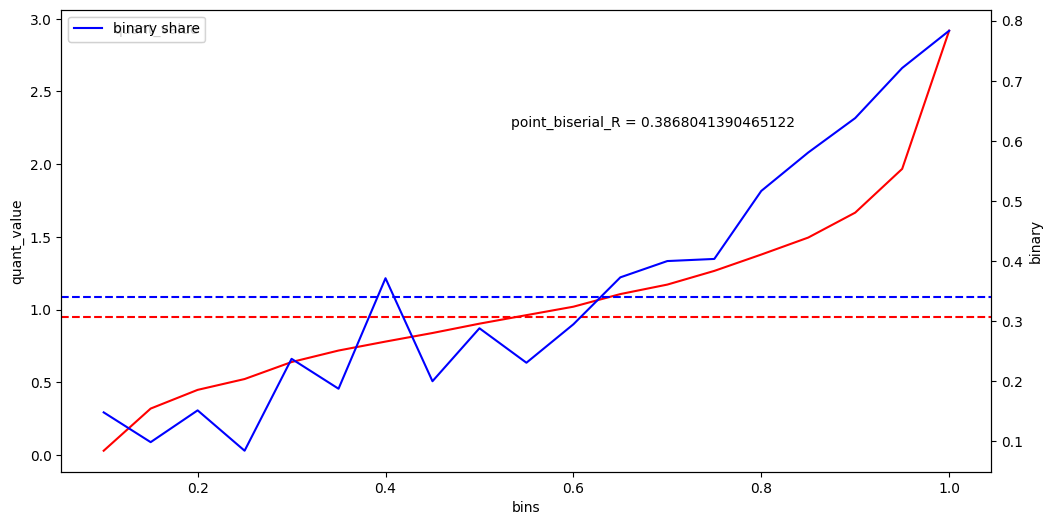

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['contacts']+1) / np.log(data['live_days']+1), binary_mask=data['is_bought']==1, step = 0.05)

### Рассмотрим метрику контакты за последние несколько дней перед уходом в архив

Метрика набора контактов за последние три дня сочетает в себе и подсчет контактов, и метрику скорости. Посмотрим, будет ли это хорошим кандидатом на эту роль

Mean quant value for group (binary=1) = 16.165024630541872
Mean quant value for group (binary=0) = 7.031766200762389
Median quant value for group (binary=1) = 10.0
Median quant value for group (binary=0) = 4.0
Kruskal-Wallis H Test p-value = 2.187389457336492e-29
T-test p-value = 1.0543457006044373e-23
point biserial correlation = 0.2848338395868965


{'point biserial R': 0.2848338395868965,
 'kruskal_pval': 2.187389457336492e-29,
 'ttest_pval': 1.0543457006044373e-23}

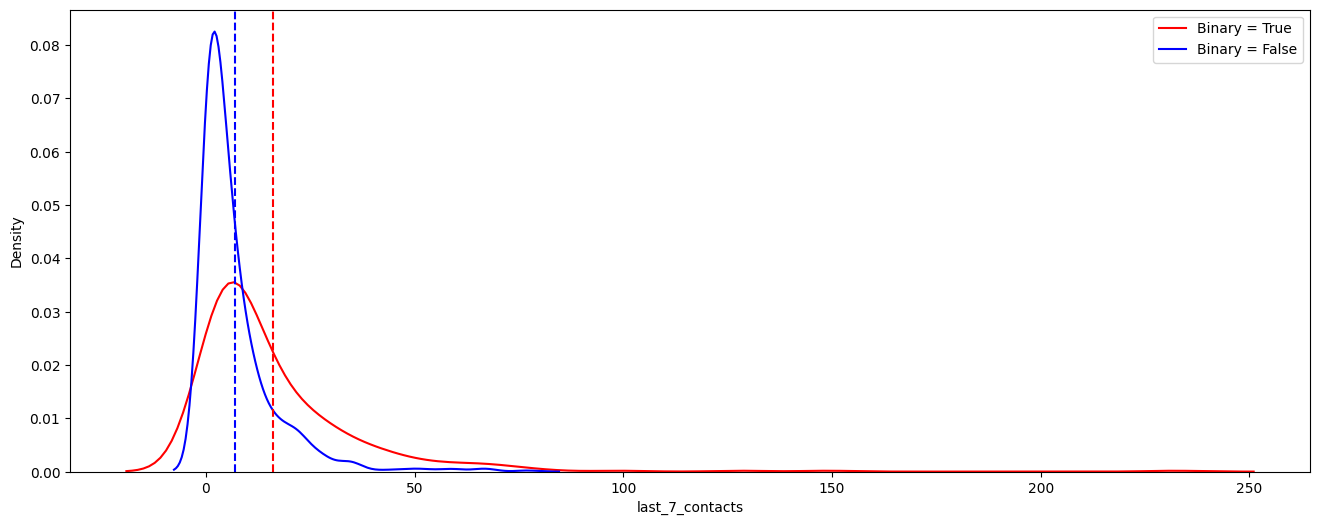

In [ ]:
find_cat_quant_correlation(quant_value = data['last_7_contacts'], binary_mask=data['is_bought']==1, plot = True, print_inference = True)

попробуем логарифмировать

Mean quant value for group (binary=1) = 2.324007522475958
Mean quant value for group (binary=0) = 1.558640441513432
Median quant value for group (binary=1) = 2.3978952727983707
Median quant value for group (binary=0) = 1.6094379124341003
Kruskal-Wallis H Test p-value = 2.187389457336492e-29
T-test p-value = 9.635689356892867e-32
point biserial correlation = 0.3302061154355892


{'point biserial R': 0.3302061154355892,
 'kruskal_pval': 2.187389457336492e-29,
 'ttest_pval': 9.635689356892867e-32}

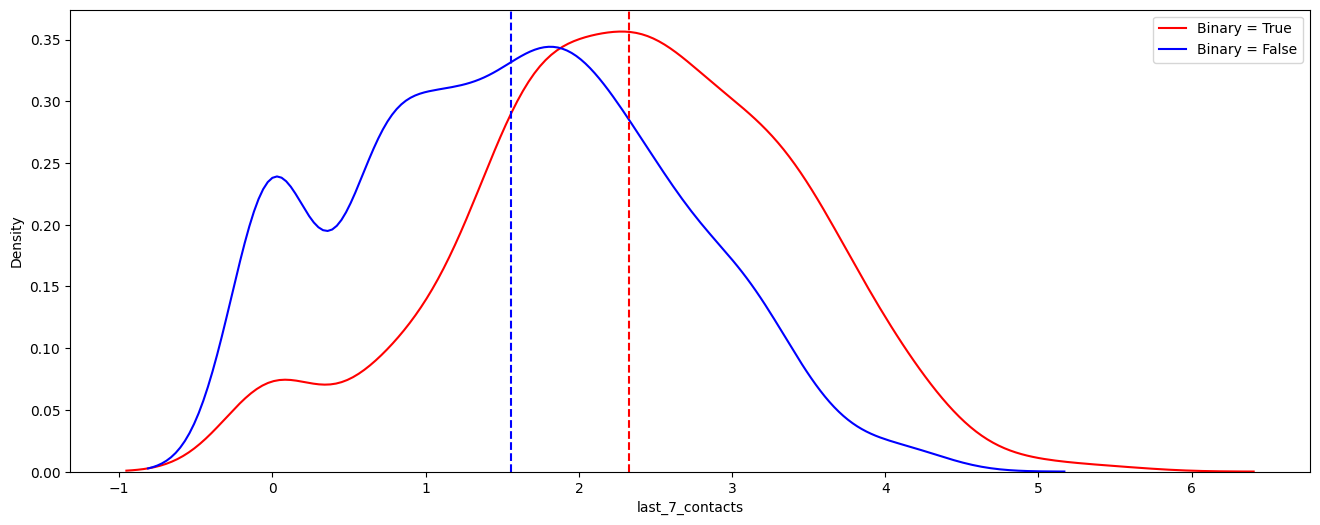

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['last_7_contacts']+1), binary_mask=data['is_bought']==1, plot = True, print_inference = True)

На графике явно видно, что группа, продавшая авто, получала перед уходом в архив больше контактов. И при этом доля тех, кто получил контактов больше 0 у "продавших" значительно ниже

Mean quant value for group (binary=1) = 1.8951297997757153
Mean quant value for group (binary=0) = 0.9424162291583609
Median quant value for group (binary=1) = 1.9459101490553132
Median quant value for group (binary=0) = 0.6931471805599453
Kruskal-Wallis H Test p-value = 2.2215577772866467e-45
T-test p-value = 6.846453497217277e-52
point biserial correlation = 0.4189125444689098


{'point biserial R': 0.4189125444689098,
 'kruskal_pval': 2.2215577772866467e-45,
 'ttest_pval': 6.846453497217277e-52}

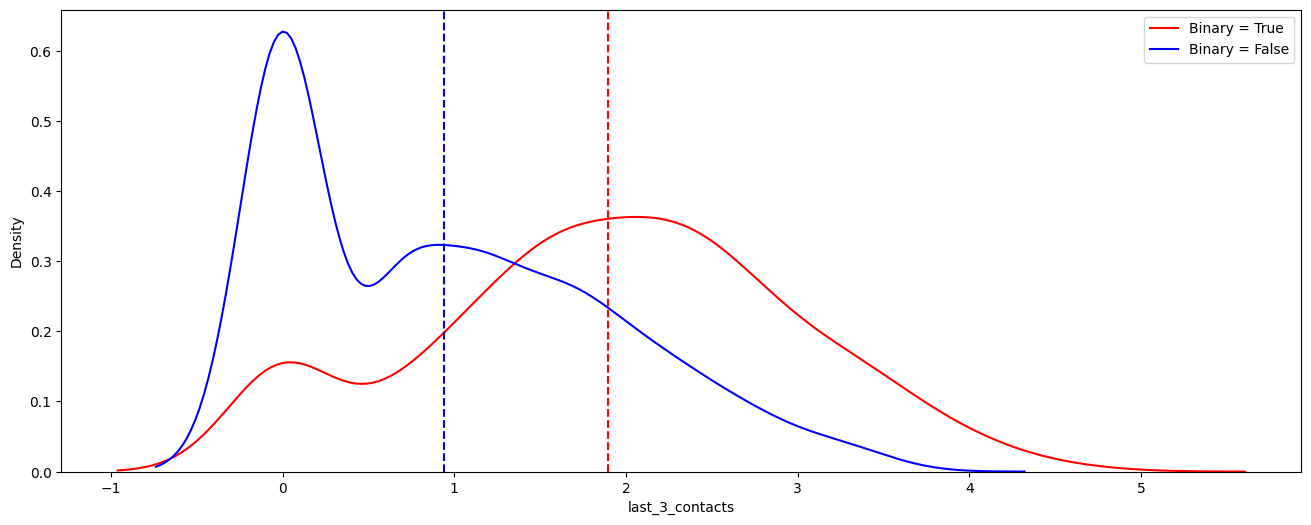

In [ ]:
find_cat_quant_correlation(quant_value = np.log(data['last_3_contacts']+1), binary_mask=data['is_bought']==1, plot = True, print_inference = True)

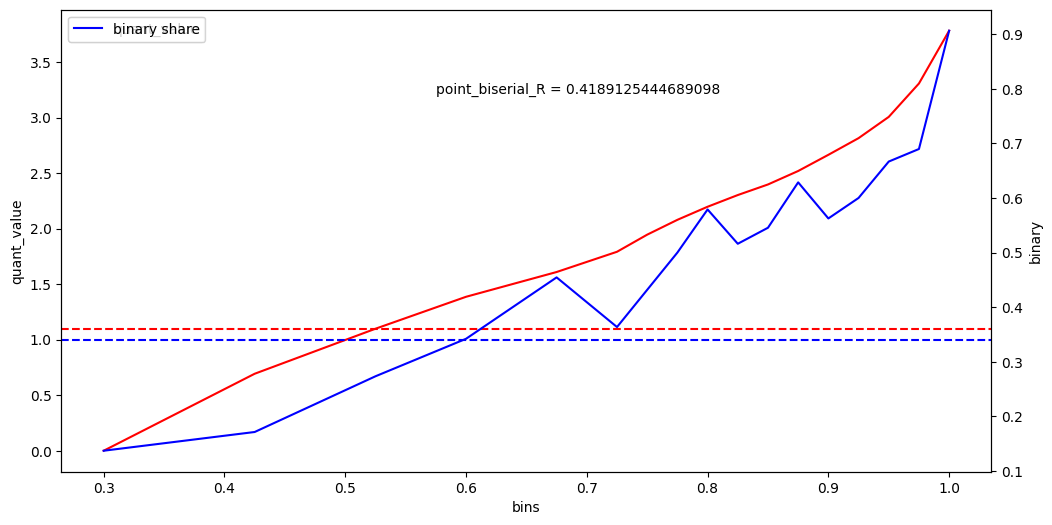

In [ ]:
proxy_metrics_bins_analizer(quant_value = np.log(data['last_3_contacts']+1), binary_mask=data['is_bought']==1, step = 0.025)

Мы нашли неплохого кандидата на роль прокси-метрики для факта продажи авто - набранное кол-во контактов за 3 дня перед уходом в архив. Теперь попробуем превратить эту метрику в бинарную.

### Перебираем пороги для максимизации корреляции между двумя бинарными метриками

Согласно визуальному анализу стоит начать перебор параметров от медианы и выше, но также необходимо посмотреть и долю пользователей не получавших контакты перед уходом в архив

In [ ]:
# доля бесконтактных
(data['last_3_contacts']== 0).sum() / len(data)

0.2933780385582565

Для оценки ассоциации (корреляции) между двумя бинарными переменными используется cramer V статистика

https://towardsdatascience.com/how-strongly-associated-are-your-variables-80493127b3a2

https://medium.com/@manindersingh120996/understanding-categorical-correlations-with-chi-square-test-and-cramers-v-a54fe153b1d6

In [ ]:
#создадим функцию для оценки ассоциации двух бинарных переменных
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    return (cramers_v)

In [ ]:
# для примера давайте рассмотрим корреляцию между следующими метриками
confusion_matrix = pd.crosstab(data['is_selling_2']=='Sold', data['last_3_contacts']>4)
cramers_v(confusion_matrix.values)

0.3413854425014344

In [ ]:
#попробуем найти порог, при котором коэффициент ассоциации cramer V будет максимальным

def max_cramerv_corr_finder(quant_value, binary_mask, plot = True, print_inference = True, step = 1):
    '''
    quant_value - исходная количественная переменная по которой мы пытаемся найти порог
    binary_mask - бинарная метрика с целевой конверсией к которой мы исщем максимальную корреляцию
    plot - нужно ли рисовать граиф
    print_inference - нужно ли принтовать выводы
    step - размер шага с которым мы идем по quant_value и определяем пороги
    '''
    # определяем вектор исходной количественной переменной, на котором мы будет искать максимальную корреляцию
    arange = np.arange(min(quant_value), max(quant_value), step)
    cramers_v_list = []

    #циклом проходим по всем порогам и находим значение cramers_v
    for i in arange:
        confusion_matrix = pd.crosstab(binary_mask, quant_value>i)
        cramers_v_i = cramers_v(confusion_matrix.values)
        cramers_v_list.append(cramers_v_i)

    # сохраняем максимальные найденные значения корреляции и порога, при котором она достигается
    max_corr_quant_value = arange[np.argmax(np.array(cramers_v_list))]
    max_cramer_v = max(cramers_v_list)

    # отрисовываем график
    if plot:
        sns.lineplot(x = arange, y = cramers_v_list)
        plt.axhline(y = np.array(cramers_v_list).max(), linestyle = '--', color = 'red')
        plt.axvline(x = max_corr_quant_value, linestyle = '--', color = 'red')
        plt.xlabel('quant values')
        plt.ylabel('Cramer-V')

    ## принтуем выводы
    if print_inference:
        print('Maximum Cramer V =', np.array(cramers_v_list).max())
        print('Maximum Cramer V quant value = ', max_corr_quant_value)

    return({'max_cramer_v': max_cramer_v,
           'max_corr_quant_value': max_corr_quant_value})

Maximum Cramer V = 0.3686253838357947
Maximum Cramer V quant value =  3


{'max_cramer_v': 0.3686253838357947, 'max_corr_quant_value': 3}

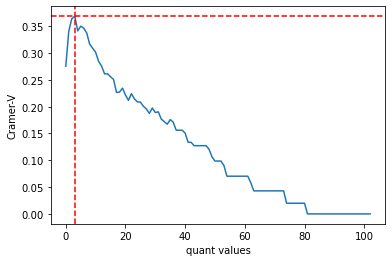

In [ ]:
max_cramerv_corr_finder(data['last_3_contacts'], data['is_selling_2']=='Sold', plot = True, print_inference = True, step = 1)

Maximum Cramer V = 0.3686253838357947
Maximum Cramer V quant value =  1.4000000000000001


{'max_cramer_v': 0.3686253838357947,
 'max_corr_quant_value': 1.4000000000000001}

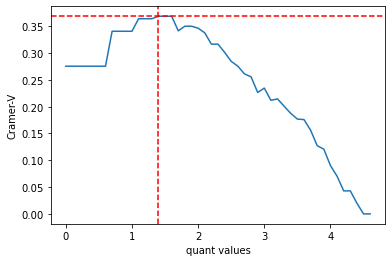

In [ ]:
# давайте попробуем прогнать этот кусочек с логарифмированной метрикой
max_cramerv_corr_finder(np.log(data['last_3_contacts']+1), data['is_selling_2']=='Sold', plot = True, print_inference = True, step = 0.1)

In [ ]:
# преобразуем в исходную шкалу полученное рекомендованное значение
np.exp(1.4)-1

3.0551999668446745

Итак мы нашли, что по историческим данным наилучшая корреляция достигается при 3+ уровне контактов за 3 дня перед отправкой в архив

### Проверим чувствительность такой метрики для теста на конверсию

Проверка через А/Б-тест заключается в том, сможем ли мы находить реальные изменения в целевой метрике, наблюдая изменения в прокси-метрике.
Для этого необходим реально проведенный А/Б-тест, где есть найденное изменение в целевой метрике.
Либо, где эффекта в целевой метрике нет, и мы смотрим, как часто наша прокси метрика говорит, что эффект все-таки есть.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/aleks-haksly/Study/main/Data/proxy_metrics_case_data.csv?token=GHSAT0AAAAAACTJMDQM4JBMC6DDJAGMJNJIZTOX5LQ')
data.head(2)

,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,max_messages_events,messages_events,messages_users,avg_contacts_delta,max_contacts_delta,min_contacts_delta,is_selling_2,mumur_advertid
0,84,2,84,39,2,2,8,0,0,0,0.0,2,-2,Yes,1491863013
1,95,0,95,36,0,0,8,0,0,0,0.0,0,0,Yes,1909318556


In [ ]:
#AA test simulation on target metric
# проведем симуляцию оценки равенства долей двумя способами. Непосредственно оценку доли проданных
# и оценку тех, кто набрал 3+ контактов за период до ухода в архив

aa_binary_ztest_pvalue_list = []
aa_quant_ztest_pvalue_list = []
quant_target_level = 3
n_sim = 100



for i in range(n_sim):
    sample_mask = ss.bernoulli.rvs(0.5, size=len(data)) == 1 # Чтобы разделить датасет на 2 случайные части генерируем маску из распределения бернулли

    binary_mask_group_a = (data['is_selling_2']=='Sold')[sample_mask] # [F, F, T, T, F, ...] разделенные по маске
    binary_mask_group_b = (data['is_selling_2']=='Sold')[~sample_mask]
    quant_value_group_a = (data['last_3_contacts'])[sample_mask] # [1, 2, 6, 20, 0,  ...] разделенные по маске
    quant_value_group_b = (data['last_3_contacts'])[~sample_mask]

    binary_nobs_group_a = len(binary_mask_group_a) # сколько в группе a по маске
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)

    binary_counts_group_a = binary_mask_group_a.sum() # сколько проданных объявлений в группе a по маске
    binary_counts_group_b = binary_mask_group_b.sum()
    quant_counts_group_a = (quant_value_group_a >= quant_target_level).sum() # сколько last_3_contacts >=3 объявлений в группе a по маске
    quant_counts_group_b = (quant_value_group_b >= quant_target_level).sum()

    #проведем z-test для оценки равенства долей в двух группах
    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b], # число проданных объявлений в каждой группе
                          nobs = [binary_nobs_group_a, binary_nobs_group_b]) # число попыток в каждой группе

    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b], # сколько last_3_contacts >=3 объявлений в каждой группе
                          nobs = [quant_nobs_group_a, quant_nobs_group_b]) # число попыток в каждой группе

    aa_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    aa_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

binary_alpha_ci = proportion_confint((np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_alpha_ci = proportion_confint((np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)

print('Количество случаев ложного прокраса теста при оценке доли продавших:', (np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum())
print('Уровень статистической значимости оценки (доля продавших):', (np.array(aa_binary_ztest_pvalue_list) <= 0.05).sum()/n_sim) # то же в долях от количестова экспериментов
print('99%-процентный доверительный интервал для уровня стат. значимости для целевой метрики (доля продавших)', binary_alpha_ci)
print('------------------')
print('Количество случаев ложного прокраса теста при оценке доли тех, кто набрал 3= контакта за 3 дня:',(np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum())
print('Уровень статистической значимости оценки (доля набравших 3+):', (np.array(aa_quant_ztest_pvalue_list) <= 0.05).sum()/n_sim)
print('99%-процентный доверительный интервал для уровня стат. значимости для прокси метрики (доля продавших)', quant_alpha_ci)

Количество случаев ложного прокраса теста при оценке доли продавших: 6
Уровень статистической значимости оценки (доля продавших): 0.06
99%-процентный доверительный интервал для уровня стат. значимости для целевой метрики (доля продавших) (0.0, 0.12117255661631254)
------------------
Количество случаев ложного прокраса теста при оценке доли тех, кто набрал 3= контакта за 3 дня: 1
Уровень статистической значимости оценки (доля набравших 3+): 0.01
99%-процентный доверительный интервал для уровня стат. значимости для прокси метрики (доля продавших) (0.0, 0.03562917797162251)


Как мы видим, уровень альфа на А/А-тестах выдерживается в заданных рамках. Посмотрим как будет вести себя на А/Б-симуляциях

In [ ]:
#AB test simulation

ab_binary_ztest_pvalue_list = []
ab_quant_ztest_pvalue_list = []
quant_target_level = 3
abs_effect = 0.1
n_sim = 1000

for i in range(n_sim):
    sample_mask = ss.bernoulli.rvs(0.5, size=len(data)) == 1

    binary_mask_group_a = (data['is_selling_2']=='Sold')[sample_mask]
    binary_mask_group_b = (data['is_selling_2']=='Sold')[~sample_mask]
    quant_value_group_a = (data['last_3_contacts'])[sample_mask]
    quant_value_group_b = (data['last_3_contacts'])[~sample_mask]

    binary_nobs_group_a = len(binary_mask_group_a)
    binary_nobs_group_b = len(binary_mask_group_b)
    quant_nobs_group_a = len(quant_value_group_a)
    quant_nobs_group_b = len(quant_value_group_b)

    binary_counts_group_a = binary_mask_group_a.sum()
    binary_counts_group_b = round(binary_mask_group_b.sum()*(1+abs_effect)) #add effect
    quant_counts_group_a = (quant_value_group_a >= quant_target_level).sum()
    quant_counts_group_b = round((quant_value_group_b >= quant_target_level).sum()*(1+abs_effect)) #add effect

    binary_z_score_i, binary_ztest_pvalue_i = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

    quant_z_score_i, quant_ztest_pvalue_i = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

    ab_binary_ztest_pvalue_list.append(binary_ztest_pvalue_i)
    ab_quant_ztest_pvalue_list.append(quant_ztest_pvalue_i)

binary_power_ci = proportion_confint((np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)
quant_power_ci = proportion_confint((np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum(), n_sim, alpha=0.01)

print('Effect =', abs_effect)
print('Sample size A group =', binary_nobs_group_a)
print('Sample size B group =', binary_nobs_group_b)

print('Target conversion A group = ', binary_counts_group_a / binary_nobs_group_a)
print('Target conversion B group = ', binary_counts_group_b / binary_nobs_group_b)
print('Proxy conversion A group = ', quant_counts_group_a / quant_nobs_group_a)
print('Proxy conversion B group = ', quant_counts_group_b / quant_nobs_group_b)



print('Мощность АБ-теста по целевой метрике', (np.array(ab_binary_ztest_pvalue_list) <= 0.05).sum() / n_sim)
print('99%-процентный доверительный интервал для мощности (доля продавших)', binary_alpha_ci)


print('Мощность АБ-теста по прокси метрике', (np.array(ab_quant_ztest_pvalue_list) <= 0.05).sum() / n_sim)

Effect = 0.1
Sample size A group = 613
Sample size B group = 587
Target conversion A group =  0.3425774877650897
Target conversion B group =  0.37649063032367974
Proxy conversion A group =  0.47797716150081565
Proxy conversion B group =  0.5383304940374787
Мощность АБ-теста по целевой метрике 0.235
99%-процентный доверительный интервал для мощности (доля продавших) (0.0, 0.12117255661631254)
Мощность АБ-теста по прокси метрике 0.405


Как мы видим, мощность теста по прокси-метрике немного выше, чем по основной. Связано это с различем в долях. Доля пользователей с кол-вом контактов больше или равно трех выше, чем тех, кто продал авто. Это разница влияет на то, какое кол-во пользователей нам необходимо, чтобы задетектить ожидаемый размер эффекта.
Поэтому на ограниченной выборке мы можем задетектить.

### Проверим, как ведет себя прокси метрика на реальном АБ-тесте

Мы решили использовать метрику "кол-во контактов за 3 дня до ухода в архив" как прокси-метрику для конверсии в продажу авто. По симуляциям метрика выглядела неплохо.

Теперь нам нужно проверить причинно-следственные связи на практике. Для этого проведем А/Б-тест, влияющий на набор контактов. И одновременно с ним будем проводить обзвон пользователей, ушедших в архив, чтобы определить, продали ли они автомобиль на самом деле.

Это позволит нам узнать истинный эффект от нововедения на долю продаваемых и эффект на набор контактов в последние 3 дня перед архивом.
Сопоставив эти два результата, мы поймем позволяет ли прокси-метрика находить эффекты на долю проданных авто.

Загрузим данные по АБ-тесту

In [ ]:
ab_test_data = pd.read_csv('proxy_metrics_case_abtest.csv')

In [ ]:
ab_test_data.head()

,views,contacts,last_7_views,last_3_views,last_7_contacts,last_3_contacts,live_days,max_messages_events,messages_events,messages_users,avg_contacts_delta,max_contacts_delta,min_contacts_delta,mumur_advertid,AB_test_group,is_selling_3
0,72,0,19,7,0,0,15,1,1,1,0.00,0,0,1228156847,0,0
1,2040,20,252,87,6,5,27,2,14,12,0.00,0,0,1111412596,1,1
2,4105,56,757,223,10,3,39,3,19,17,0.00,0,0,2292183779,1,0
3,4568,39,854,236,7,3,41,3,29,23,-0.17,2,-2,772897149,1,1
4,56,3,56,10,3,4,7,0,0,0,0.00,2,-1,1598865363,1,1


In [ ]:
# посмотрим есть ли различия в доле продающих пользователей между двумя группами
print((ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==1]).mean())
print((ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==0]).mean())

0.3665997993981946
0.33732136922565636


In [ ]:
# посмотрим есть ли различия в доле пользователей, набравших больше 3 контактов между двумя группами
print((ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==1] > 3).mean())
print((ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==0] > 3).mean())

0.4745904379806085
0.4230641409106015


Даже беглый взгляд говорит, что мы можем детектить эффект и через прокси метрику. Давайте посмотрим, что скажут стат критерии.

In [ ]:
# АБ-тест доли продавших
binary_counts_group_a = (ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==0]).sum()
binary_counts_group_b = (ab_test_data['is_selling_3'][ab_test_data['AB_test_group']==1]).sum()

binary_nobs_group_a = len(ab_test_data[ab_test_data['AB_test_group']==0])
binary_nobs_group_b = len(ab_test_data[ab_test_data['AB_test_group']==1])

binary_z_score, binary_ztest_pvalue = sms.proportions_ztest(count = [binary_counts_group_a, binary_counts_group_b],
                          nobs = [binary_nobs_group_a, binary_nobs_group_b])

print('Proportion abs uplift:', (binary_counts_group_b/binary_nobs_group_b) - (binary_counts_group_a/binary_nobs_group_a))
print('Proportion rel uplift:', (binary_counts_group_b/binary_nobs_group_b)/(binary_counts_group_a/binary_nobs_group_a) - 1)
print('Z-test p-value:', binary_ztest_pvalue)

Proportion abs uplift: 0.029278430172538228
Proportion rel uplift: 0.08679684373316987
Z-test p-value: 0.0007852964424626157


In [ ]:
# АБ-тест доли набравших 3+
quant_counts_group_a = (ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==0] > 3).sum()
quant_counts_group_b = (ab_test_data['last_3_contacts'][ab_test_data['AB_test_group']==1] > 3).sum()

quant_nobs_group_a = len(ab_test_data[ab_test_data['AB_test_group']==0])
quant_nobs_group_b = len(ab_test_data[ab_test_data['AB_test_group']==1])

quant_z_score, quant_ztest_pvalue = sms.proportions_ztest(count = [quant_counts_group_a, quant_counts_group_b],
                          nobs = [quant_nobs_group_a, quant_nobs_group_b])

print('Proportion abs uplift:', (quant_counts_group_b/quant_nobs_group_b) - (quant_counts_group_a/quant_nobs_group_a))
print('Proportion rel uplift:', (quant_counts_group_b/quant_nobs_group_b)/(quant_counts_group_a/quant_nobs_group_a) - 1)
print('Z-test p-value:', quant_ztest_pvalue)

Proportion abs uplift: 0.051526297070007
Proportion rel uplift: 0.12179310909949015
Z-test p-value: 1.3926986115308757e-08


Как мы видим в обоих метриках есть изменения в доле. Это говорит о том, что мы можем использовать  данную прокси-метрику для того, чтобы находить эффекты в целевой метрике.